<a href="https://colab.research.google.com/github/mns0/Relix/blob/main/DataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install folium


In [19]:
import numpy as np
import os
import glob
import re


In [23]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cat: /content/drive: Is a directory


In [27]:
!ls /content/drive/MyDrive/Relix_data

d6562590a4d849df84bccf351bc38cc9_0.geojson
data
DataExploration.ipynb
DataFrame_Processed.pkl
DataModeling.ipynb
data.tgz
minimally_processed_trajectories.pkl


In [32]:

_dir = "/content/drive/MyDrive/Relix_data/data"
files = glob.glob(_dir + "/*js")

def action_goto_parse(line):
    ret = []
    line = re.sub(chr(39),"", line)
    re_str = "\)"
    line = re.sub(re_str,"", line)
    line = re.split('\(',line)
    return line

    
def action_click_parse(line):
    re_str = "click\("
    line = re.sub(re_str,"", line)[:-1]
    ret = ["click"]
    ret.append(line)
    return ret
    
    
def action_write_parse(line):
    re_str = "write\("
    line = re.sub(re_str,"", line)[:-1].split(",",1)
    ret = ["write"]
    if "into(textBox(near('Email')))" in line[1]:
        ret.append("email")
    elif "int(textBox('Enter a location'))" in line[1]:
        ret.append("location")
    elif "into(textBox('City, state, or zip'))" in line[1]:
        ret.append("citystatezip")
    elif "Estimated home value" in line[1]:
        ret.append("homeValue")
    elif "Whats the expected monthly rental income?" in line[1]:
        ret.append("monthlyRental")
    else:
        ret.append("NOMATCH")
    ret.append(line[0].replace(chr(39), ""))
    return ret 


def process_raw_trajectory(fh):
    ret = []
    for line in fh:
        re_str = "await|;|// <--- user entered text|// <=== choice presented to user|\n|\t|https://"
        line = re.sub(re_str,"", line).strip()
        if 'goto' in line:
            ret.append(action_goto_parse(line))
        elif 'click' in line:
            ret.append(action_click_parse(line))
        elif 'write' in line:
            ret.append(action_write_parse(line))
        else:
            #Filter out scrollEvents. 
            pass
            #ret.append("CANT FIND MATCH")
            #ret.append(line)
    return ret


list_of_sessions_raw = []
check = set()
for file in files:
    with open(file) as f:
        parsed_session_output = process_raw_trajectory(f)
        
    list_of_sessions_raw.append(parsed_session_output)



In [4]:
#serialize and save the data
import pickle
pickle_file_name = "minimally_processed_trajectories.pkl"
with open(pickle_file_name, 'wb') as f:
    pickle.dump(list_of_sessions_raw, f, pickle.HIGHEST_PROTOCOL)


In [5]:
with open(pickle_file_name, 'rb') as f:
    data = pickle.load(f)

In [6]:
#Determine the features 
#Click State Features 
click_event_states = set()
write_event_states = set()
for traj in data:
    flag = False
    for event in traj:
        #filter out CANT FIND MATCH and NOMatch keywords
        if  len(event) > 0 and event[0] == 'write':
            write_event_states.add(event[1])
        if 0 < len(event) < 3 and event[0] == 'click' and\
            "CityNameWithZipCode" not in event[1] and not event[1][1:4].isdigit():
            click_event_states.add(event[1])
            

feature_vector = ['goto'] + list(click_event_states) + list(write_event_states)


In [7]:
data_matrix = np.empty((len(data),len(feature_vector) ), dtype=np.dtype('U100'))
feature_vector_to_idx = {feature : i for i, feature in enumerate(feature_vector)}

for idx, traj in enumerate(data):
    for event in traj:
        if len(event) > 5 or len(event) == 0:
            continue
        if event[0] == "goto":
            data_matrix[idx][0] = event[1]
        elif event[0] == "click" and "CityNameWithZipCode" not in event[1] and not event[1][1:4].isdigit():
            matrix_idx = feature_vector_to_idx[event[1]]
            data_matrix[idx][matrix_idx] = "1"
        elif event[0] == "click" and "CityNameWithZipCode" not in event[1] and event[1][1:4].isdigit(): #handle the address
            matrix_idx = feature_vector_to_idx["location"]
            data_matrix[idx][matrix_idx] = event[1]
        elif len(event) > 0 and event[0] == 'write' and event[1] != 'location':
            matrix_idx = feature_vector_to_idx[event[1]]
            data_matrix[idx][matrix_idx] = event[2]
            


In [8]:
#import into pandas
import pandas as pd
df = pd.DataFrame(data=data_matrix, columns=feature_vector)
df = df.apply(lambda x: x.str.strip()).replace('', np.nan)


In [9]:
file_name = "DataFrame_Processed.pkl"
df.to_pickle(path=file_name)
df.head()

,goto


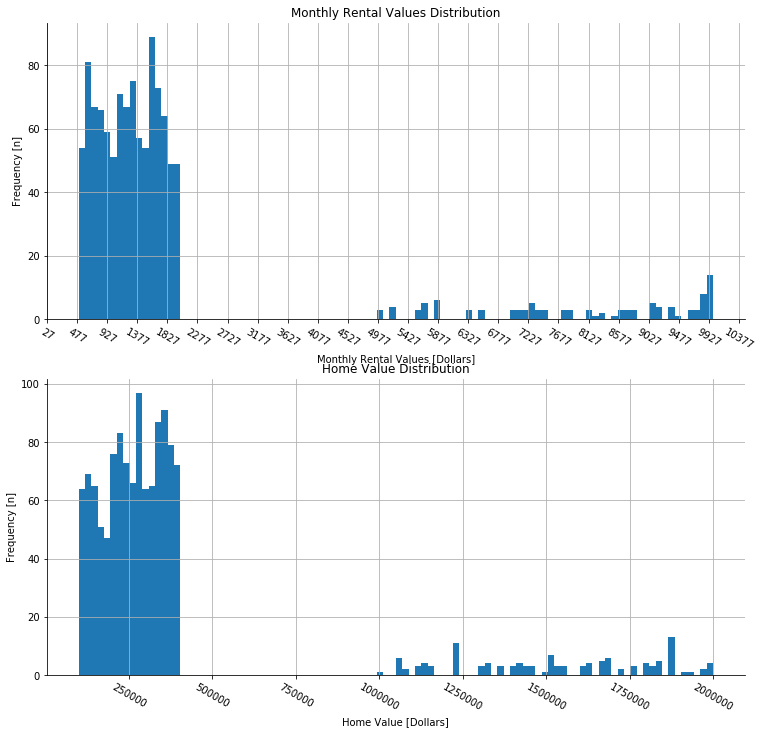

In [ ]:
#Plot distributions of the features
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
figsize(12.5, 12)

plt.subplot(211)
plt.title("Monthly Rental Values Distribution")
plt.xlabel("Monthly Rental Values [Dollars]")
plt.ylabel("Frequency [n]")
ax = df['monthlyRental'].astype("float").hist(bins=100, xrot = 330)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
start, end = ax.get_xlim()
_ = ax.xaxis.set_ticks(np.arange(start, end, 450))



plt.subplot(212)
plt.title("Home Value Distribution")
plt.xlabel("Home Value [Dollars]")
plt.ylabel("Frequency [n]")
ax = df['homeValue'].astype("float").hist(bins=100, xrot = 330)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#start, end = ax.get_xlim()
#_ = ax.xaxis.set_ticks(np.arange(start, end, ))



In [ ]:
#interprete zipcode data
import folium
import json
from folium import plugins

numStoresSeries = df.groupby('citystatezip').count().goto
numStoresByZip = pd.DataFrame()
numStoresByZip['zipcode'] = [str(i) for i in numStoresSeries.index]
numStoresByZip['numStores'] = numStoresSeries.values

In [ ]:
m = folium.Map(location=[ 33.7,  -84.3], zoom_start=10)
_dir = '.'
state_geo = f'{_dir}/d6562590a4d849df84bccf351bc38cc9_0.geojson'

m.choropleth(geo_data=state_geo,data=numStoresByZip, 
             columns=['zipcode', 'numStores'],
             key_on='feature.properties.NAME', 
             fill_color='OrRd', fill_opacity=0.5)

folium.LayerControl().add_to(m)
m

/Users/manish/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


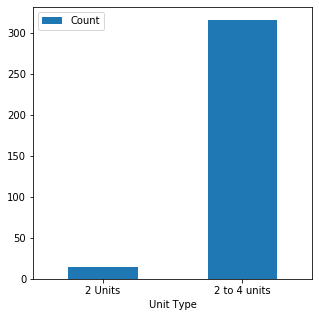

In [ ]:
df_number_of_units = pd.DataFrame()
index = ["2 Units", "2 to 4 units"]
figsize(5, 5)

df_number_of_units = pd.DataFrame({'Unit Type':['2 Units', '2 to 4 units'], 
                   'Count':[df["near('2 Units')"].astype("float").sum(),
                   df["near('2 to 4 units')"].astype("float").sum()]})

ax = df_number_of_units.plot.bar(x='Unit Type', y='Count', rot=0)
